## Training and Evaluating the Model

### Imports

In [24]:
import json
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import poisson
from sklearn.svm import SVR
from sklearn.base import BaseEstimator
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder

#### Setup imports path


In [2]:
import sys
import os

from dotenv import find_dotenv, load_dotenv
backend_dir = os.path.dirname(find_dotenv())
sys.path.insert(0, backend_dir)
print(backend_dir)

/Users/loughlindavidson/Documents/development/EPL_project/EPL_ML_PREDICTOR/backend


### Loading the Data

In [3]:
from app.services.data_processing.data_loader import load_training_data
df = load_training_data()
df.head()

,match_id,season,week,day,date,time,home_team_id,away_team_id,home_goals,away_goals,...,referee,match_report,notes,home_team,away_team,home_team_fullname,away_team_fullname,Score,FTHG,FTAG
0,1,2014-2015,1,Sat,2014-08-16,12:45:00,2,27,1,2,...,Mike Dean,Match Report,None,Manchester Utd,Swansea City,Manchester United,Swansea City,1-2,1,2
1,2,2014-2015,1,Sat,2014-08-16,15:00:00,21,26,0,1,...,Anthony Taylor,Match Report,None,Stoke City,Aston Villa,Stoke City,Aston Villa,0-1,0,1
2,3,2014-2015,1,Sat,2014-08-16,15:00:00,10,25,2,2,...,Mike Dean,Match Report,None,Leicester City,Everton,Leicester City,Everton,2-2,2,2
3,4,2014-2015,1,Sat,2014-08-16,15:00:00,5,8,0,1,...,Craig Pawson,Match Report,None,QPR,Hull City,Queens Park Rangers,Hull City,0-1,0,1
4,5,2014-2015,1,Sat,2014-08-16,15:00:00,16,19,0,1,...,Chris Foy,Match Report,None,West Ham,Tottenham,West Ham,Tottenham Hotspur,0-1,0,1


### Data Cleaning

In [4]:
from app.services.data_processing.data_loader import clean_data

df = clean_data(df)
df.head()

,match_id,season,week,day,date,time,home_team_id,away_team_id,home_goals,away_goals,...,referee,match_report,notes,home_team,away_team,home_team_fullname,away_team_fullname,Score,FTHG,FTAG
0,1,2014-2015,1,Sat,2014-08-16,12:45:00,2,27,1,2,...,Mike Dean,Match Report,None,Manchester Utd,Swansea City,Manchester United,Swansea City,1-2,1,2
1,2,2014-2015,1,Sat,2014-08-16,15:00:00,21,26,0,1,...,Anthony Taylor,Match Report,None,Stoke City,Aston Villa,Stoke City,Aston Villa,0-1,0,1
2,3,2014-2015,1,Sat,2014-08-16,15:00:00,10,25,2,2,...,Mike Dean,Match Report,None,Leicester City,Everton,Leicester City,Everton,2-2,2,2
3,4,2014-2015,1,Sat,2014-08-16,15:00:00,5,8,0,1,...,Craig Pawson,Match Report,None,QPR,Hull City,Queens Park Rangers,Hull City,0-1,0,1
4,5,2014-2015,1,Sat,2014-08-16,15:00:00,16,19,0,1,...,Chris Foy,Match Report,None,West Ham,Tottenham,West Ham,Tottenham Hotspur,0-1,0,1


### Preprocess data

In [ ]:
from app.services.models.train import preprocess_data

X, y = preprocess_data(df)


/Users/loughlindavidson/Documents/development/EPL_project/EPL_ML_PREDICTOR/backend/app/services/data_processing/feature_engineering.py:144: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(rolling_dfs, ignore_index=False)


## Features and Labels

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale your features
scaler = StandardScaler()
X = scaler.fit_transform(X)

Features are 
 ['home_team_encoded', 'away_team_encoded', 'week', 'hour', 'day_code', 'venue_code', 'season_encoded', 'ppg_rolling_h', 'ppg_rolling_a', 'gf_rolling_h', 'ga_rolling_h', 'sh_rolling_h', 'sot_rolling_h', 'pk_rolling_h', 'pkatt_rolling_h', 'gf_rolling_a', 'ga_rolling_a', 'sh_rolling_a', 'sot_rolling_a', 'pk_rolling_a', 'pkatt_rolling_a']


KeyError: "['ppg_rolling_h', 'ppg_rolling_a', 'gf_rolling_h', 'ga_rolling_h', 'sh_rolling_h', 'sot_rolling_h', 'pk_rolling_h', 'pkatt_rolling_h', 'gf_rolling_a', 'ga_rolling_a', 'sh_rolling_a', 'sot_rolling_a', 'pk_rolling_a', 'pkatt_rolling_a'] not in index"

### Training Split

In [ ]:
# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.preprocessing import StandardScaler
# Scale your features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

## Model Selection and Evaluation

In [9]:
def evaluate_model(
    model, X_train, X_val, y_train, y_val, target_names=["FTHG", "FTAG"]
):
    """
    Evaluate a multi-output regression model and visualize its performance.

    Parameters:
    - model: The regression model to evaluate.
    - X_train: Training feature data.
    - X_val: Test feature data.
    - y_train: Training target data (multi-output).
    - y_val: Test target data (multi-output).
    - target_names: List of target variable names (e.g., ['FTHG', 'FTAG']).

    Returns:
    - Metrics: Dictionary containing MAE, MSE, RMSE, R2 for each target.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # Calculate evaluation metrics
    metrics = {}
    metrics["MAE"] = mean_absolute_error(y_val, y_pred, multioutput="uniform_average")
    metrics["R2"] = r2_score(y_val, y_pred, multioutput="uniform_average")

    print("Mean Absolute Error (MAE):", metrics["MAE"])
    print("R-squared (R2):", metrics["R2"])

    # Visualization
    plt.figure(figsize=(8, 4))

    for i, target_name in enumerate(target_names):
        plt.subplot(1, len(target_names), i + 1)
        plt.scatter(y_val[target_name], y_pred[:, i], color="blue", label="Predicted")
        plt.xlabel(f"Actual {target_name}")
        plt.ylabel(f"Predicted {target_name}")
        plt.title(f"Actual vs. Predicted {target_name}")
        plt.plot(
            [y_val[target_name].min(), y_val[target_name].max()],
            [y_val[target_name].min(), y_val[target_name].max()],
            color="red",
            linestyle="--",
        )
        plt.legend()

    plt.tight_layout()
    plt.show()

    return metrics

### Non-classification models

The models considered were Linear Regression, Random Forest Regressor, Gradient Boosting Machines, and Support Vector Machines. However since we are predicting discrete values (FTHG and FTAG), a model which predicts discrete values would fit this problem better.

In [10]:
# Initialize a DataFrame to store results
results_df = pd.DataFrame()

def evaluate_model_performance(y_true, y_pred, model_name):
    y_true = y_true.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)

    # Calculate metrics
    mae_home = mean_absolute_error(y_true["FTHG"], y_pred["FTHG"])
    mae_away = mean_absolute_error(y_true["FTAG"], y_pred["FTAG"])
    r2_home = r2_score(y_true["FTHG"], y_pred["FTHG"])
    r2_away = r2_score(y_true["FTAG"], y_pred["FTAG"])
    rmse_home = root_mean_squared_error(y_true["FTHG"], y_pred["FTHG"])
    rmse_away = root_mean_squared_error(y_true["FTAG"], y_pred["FTAG"])
    mae_total = (mae_home + mae_away) / 2
    rmse_total = (rmse_home + rmse_away) / 2

    exact_matches = np.sum((y_true["FTHG"] == y_pred["FTHG"]) & (y_true["FTAG"] == y_pred["FTAG"]))
    exact_match_percentage = 100 * exact_matches / len(y_true)
    goal_diff_true = y_true["FTHG"] - y_true["FTAG"]
    goal_diff_pred = y_pred["FTHG"] - y_pred["FTAG"]
    goal_diff_accuracy = np.mean(np.sign(goal_diff_true) == np.sign(goal_diff_pred))

    true_result = np.select(
        [y_true["FTHG"] > y_true["FTAG"], y_true["FTHG"] < y_true["FTAG"]],
        choicelist=["W", "L"],
        default="D",
    )
    pred_result = np.select(
        [y_pred["FTHG"] > y_pred["FTAG"], y_pred["FTHG"] < y_pred["FTAG"]],
        choicelist=["W", "L"],
        default="D",
    )
    correct_results_percentage = 100 * np.sum(pred_result == true_result) / pred_result.shape[0]

    # Store results
    result = {
        "Model": model_name,
        "MAE_Home": mae_home,
        "MAE_Away": mae_away,
        "MAE_Total": mae_total,
        "RMSE_Home": rmse_home,
        "RMSE_Away": rmse_away,
        "RMSE_Total": rmse_total,
        "R2_Home": r2_home,
        "R2_Away": r2_away,
        "Exact_Match_%": exact_match_percentage,
        "Goal_Diff_Accuracy": goal_diff_accuracy,
        "Correct_Result_%": correct_results_percentage,
    }
    return result

In [12]:
class MedianPredictor(BaseEstimator):
    """
    A custom scikit-learn compatible estimator that predicts the median values of targets.
    Designed for multi-output regression, predicting FTHG and FTAG based on training data medians.
    """
    def __init__(self):
        self.median = None

    def fit(self, X, y):
        self.median = y.median()
        return self

    def predict(self, X):
        n_samples = X.shape[0] if isinstance(X, np.ndarray) else len(X)
        y_pred = np.array([self.median] * n_samples)
        return y_pred

In [15]:
class DixonColesPredictor(BaseEstimator):
    """
    A scikit-learn compatible estimator for the Dixon-Coles model, predicting football match scores
    using a Poisson distribution with correlation adjustment.

    Parameters:
    - target_names: List of target variable names (default: ['FTHG', 'FTAG']).
    - team_col: Column name for team identifiers (default: 'team').
    """
    def __init__(self, target_names=["FTHG", "FTAG"], team_col="team"):
        self.target_names = target_names
        self.team_col = team_col
        self.attack_params = {}  # Team-specific attack strengths
        self.defense_params = {}  # Team-specific defense strengths
        self.home_advantage = 0.0  # Home advantage parameter
        self.theta = 0.0  # Correlation parameter
        self.teams = None  # Unique teams in the dataset

    def _poisson_pmf(self, home_goals, lambda_H, away_goals, lambda_A):
        """Calculate the Poisson PMF with correlation adjustment."""
        prob_home = poisson.pmf(home_goals, lambda_H)
        prob_away = poisson.pmf(away_goals, lambda_A)
        return prob_home * prob_away * np.exp(self.theta * min(home_goals, away_goals))

    def _dixon_coles_likelihood(self, params, data):
        """Compute the negative log-likelihood for the Dixon-Coles model."""
        n_teams = len(self.teams)
        attack = params[:n_teams]
        defense = params[n_teams:2*n_teams]
        self.home_advantage = params[-2]
        self.theta = params[-1]

        log_likelihood = 0
        for index, row in data.iterrows():
            home_team = row["home_team_encoded"]
            away_team = row["away_team_encoded"]
            h = row["FTHG"]
            a = row["FTAG"]

            home_idx = self.teams.get_loc(home_team)
            away_idx = self.teams.get_loc(away_team)

            lambda_H = np.exp(attack[home_idx] + defense[away_idx] + self.home_advantage)
            lambda_A = np.exp(attack[away_idx] + defense[home_idx])

            log_likelihood += np.log(self._poisson_pmf(h, lambda_H, a, lambda_A))

        return -log_likelihood

    def fit(self, X, y):
        """
        Fit the Dixon-Coles model by optimizing team-specific parameters and correlation.

        Parameters:
        - X: Training feature data (DataFrame with 'home_team_encoded' and 'away_team_encoded' columns).
        - y: Training target data (DataFrame with 'FTHG' and 'FTAG' columns).

        Returns:
        - self: Fitted estimator.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        if not all(col in X.columns for col in ["home_team_encoded", "away_team_encoded"]):
            raise ValueError("X must contain 'home_team_encoded' and 'away_team_encoded' columns")
        if not all(col in y.columns for col in self.target_names):
            raise ValueError(f"y must contain columns: {self.target_names}")

        # Combine X and y for likelihood computation
        data = pd.concat([X[["home_team_encoded", "away_team_encoded"]], y], axis=1)
        
        # Get unique teams
        self.teams = pd.Index(np.unique(np.concatenate([X["home_team_encoded"].values, X["away_team_encoded"].values])))
        n_teams = len(self.teams)

        # Initialize parameters: attack and defense for each team, home advantage, theta
        initial_params = [1.0] * (2 * n_teams) + [0.1, 0.0]  # attack, defense, home_advantage, theta

        # Optimize parameters
        result = minimize(
            self._dixon_coles_likelihood,
            initial_params,
            args=(data,),
            method="Nelder-Mead",
            options={'maxiter': 1000}
        )

        # Store optimized parameters
        attack = result.x[:n_teams]
        defense = result.x[n_teams:2*n_teams]
        self.home_advantage = result.x[-2]
        self.theta = result.x[-1]

        for i, team in enumerate(self.teams):
            self.attack_params[team] = attack[i]
            self.defense_params[team] = defense[i]

        return self

    def predict(self, X):
        """
        Predict FTHG and FTAG using the fitted Dixon-Coles model.

        Parameters:
        - X: Input feature data (DataFrame with 'home_team' and 'away_team' columns).

        Returns:
        - y_pred: Predicted values (DataFrame with 'FTHG' and 'FTAG' columns).
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame with 'home_team' and 'away_team' columns")
        if not all(col in X.columns for col in ["home_team", "away_team"]):
            raise ValueError("X must contain 'home_team' and 'away_team' columns")

        y_pred = []
        for _, row in X.iterrows():
            home_team = row["home_team_encoded"]
            away_team = row["away_team_encoded"]

            if home_team not in self.teams or away_team not in self.teams:
                # Default to average lambda if team is unseen
                lambda_H = np.exp(1.0 + self.home_advantage)
                lambda_A = np.exp(1.0)
            else:
                home_idx = self.teams.get_loc(home_team)
                away_idx = self.teams.get_loc(away_team)
                lambda_H = np.exp(self.attack_params[home_team] + self.defense_params[away_team] + self.home_advantage)
                lambda_A = np.exp(self.attack_params[away_team] + self.defense_params[home_team])

            # Predict as the expected value (rounded for discrete goals)
            pred_home = np.round(lambda_H).astype(int)
            pred_away = np.round(lambda_A).astype(int)
            y_pred.append([pred_home, pred_away])

        return pd.DataFrame(y_pred, columns=self.target_names)

### Model Comparison

In [ ]:
# Define models
models = {
    "Linear Regression": (LinearRegression(), LinearRegression()),
    "Gradient Boosting": (GradientBoostingRegressor(n_estimators=300, random_state=42), 
                         GradientBoostingRegressor(n_estimators=300, random_state=42)),
    "SVM": (SVR(), SVR()),
    "Poisson Regression": (PoissonRegressor(), PoissonRegressor()),
    "Random Forest": (RandomForestRegressor(n_estimators=100, random_state=42), 
                     RandomForestRegressor(n_estimators=100, random_state=42)),
    "Median Predictor": (MedianPredictor(), MedianPredictor()),  # Single model for both targets
}

results_df = pd.DataFrame()
# Evaluate all models
for model_name, (model_home, model_away) in models.items():
    print(model_name)
    model_home.fit(X_train, y_train["FTHG"])
    model_away.fit(X_train, y_train["FTAG"])
    y_pred_home = np.round(model_home.predict(X_val)).astype(int)
    y_pred_away = np.round(model_away.predict(X_val)).astype(int)
    y_pred = pd.DataFrame({"FTHG": y_pred_home, "FTAG": y_pred_away})
    result = evaluate_model_performance(y_val, y_pred, model_name)
    results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)

# Evaluate Neural Network separately due to different API
# nn_model = Sequential([
#     Input(shape=(X_train.shape[1],)),
#     Dense(64, activation="relu"),
#     Dense(64, activation="relu"),
#     Dense(y_train.shape[1]),
# ])
# nn_model.compile(optimizer=Adam(learning_rate=0.01), loss="mean_squared_error")
# nn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
# y_pred_nn = np.round(nn_model.predict(X_val)).astype(int)
# y_pred_nn = pd.DataFrame({"FTHG": y_pred_nn[:, 0], "FTAG": y_pred_nn[:, 1]})
# result_nn = evaluate_model_performance(y_val, y_pred_nn, "Neural Network")
# results_df = pd.concat([results_df, pd.DataFrame([result_nn])], ignore_index=True)


# Dixon Coles Model
dc_model = DixonColesPredictor(target_names=["FTHG", "FTAG"])
dc_model.fit(X_train, y_train)
y_pred_dc = dc_model.predict(X_val)
result_dc = evaluate_model_performance(y_val, y_pred_dc, "Dixon Coles")
results_df = pd.concat([results_df, pd.DataFrame([result_dc])], ignore_index=True)

# Display results
print(results_df.round(3))

Linear Regression
Gradient Boosting
SVM
Poisson Regression


/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Random Forest
Median Predictor


KeyboardInterrupt: 

#### Linear Regression Model

In [27]:
# Define parameter grid for tuning alpha
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}

# Initialize results DataFrame
results_df = pd.DataFrame()

# Lasso Regression
lasso_home = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
lasso_away = GridSearchCV(Lasso(), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
lasso_home.fit(X_train_scaled, y_train["FTHG"])
lasso_away.fit(X_train_scaled, y_train["FTAG"])
y_pred_home_lasso = np.round(lasso_home.predict(X_val_scaled)).astype(int)
y_pred_away_lasso = np.round(lasso_away.predict(X_val_scaled)).astype(int)
y_pred_lasso = pd.DataFrame({"FTHG": y_pred_home_lasso, "FTAG": y_pred_away_lasso})
lasso_results = evaluate_model_performance(y_val, y_pred_lasso, "Lasso Regression")
results_df = pd.concat([results_df, pd.DataFrame([lasso_results])], ignore_index=True)
print(f"Best alpha for Lasso (FTHG): {lasso_home.best_params_['alpha']}")
print(f"Best alpha for Lasso (FTAG): {lasso_away.best_params_['alpha']}")

# Ridge Regression
ridge_home = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
ridge_away = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
ridge_home.fit(X_train_scaled, y_train["FTHG"])
ridge_away.fit(X_train_scaled, y_train["FTAG"])
y_pred_home_ridge = np.round(ridge_home.predict(X_val_scaled)).astype(int)
y_pred_away_ridge = np.round(ridge_away.predict(X_val_scaled)).astype(int)
y_pred_ridge = pd.DataFrame({"FTHG": y_pred_home_ridge, "FTAG": y_pred_away_ridge})
ridge_results = evaluate_model_performance(y_val, y_pred_ridge, "Ridge Regression")
results_df = pd.concat([results_df, pd.DataFrame([ridge_results])], ignore_index=True)
print(f"Best alpha for Ridge (FTHG): {ridge_home.best_params_['alpha']}")
print(f"Best alpha for Ridge (FTAG): {ridge_away.best_params_['alpha']}")

# Display results
print(results_df.round(3))

/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/panda

NameError: name 'X_val_scaled' is not defined

#### Support Vector Machines (SVM) for Multi-Output Regression


### Poisson Regression
**Why**: <br>
Goals in football matches can often be modeled as Poisson-distributed, as the number of goals scored in a game is a count of independent scoring events.

**How**: <br>
Use a Generalized Linear Model (GLM) with a Poisson distribution, where the targets (FTHG and FTAG) are assumed to follow a Poisson distribution with means that depend on the input features.

**Implementation**: <br>
You can use libraries like statsmodels or scikit-learn for Poisson regression. This can directly model integer outputs and is interpretable.


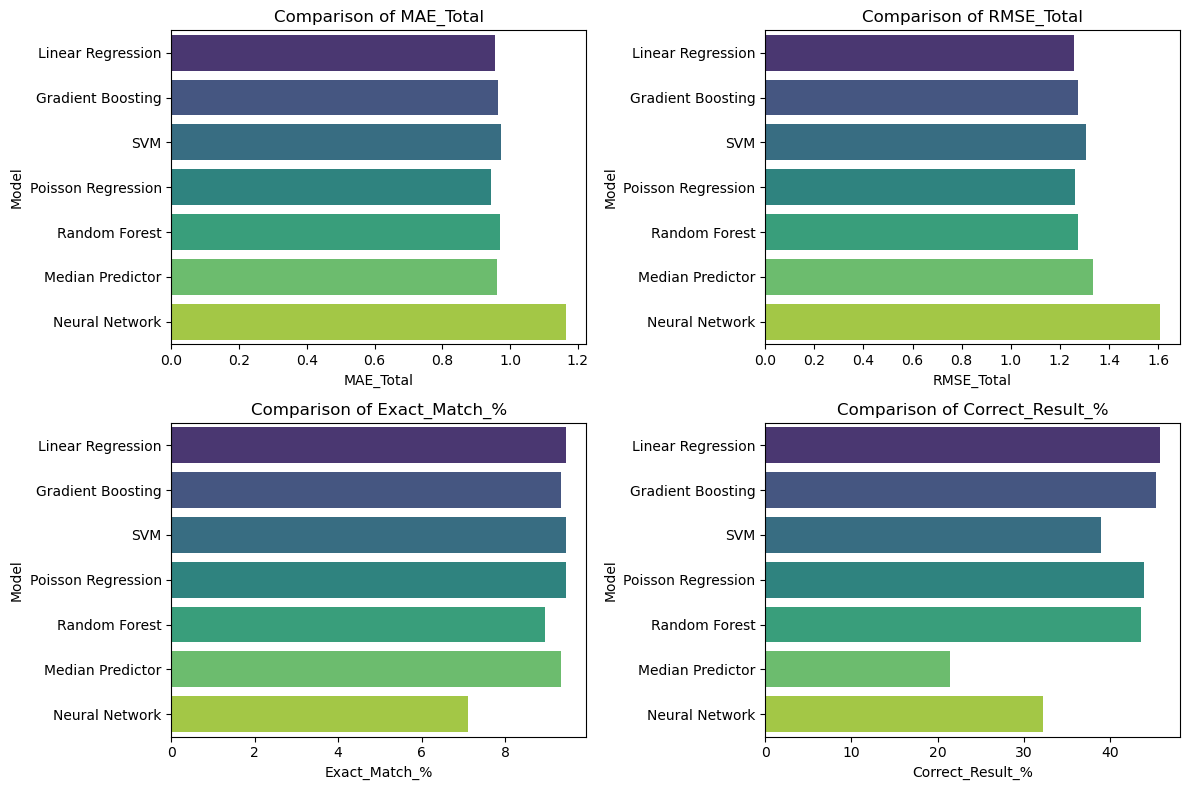

In [ ]:
# Bar chart for key metrics
metrics_to_plot = ["MAE_Total", "RMSE_Total", "Exact_Match_%", "Correct_Result_%"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(x=metric, y="Model", data=results_df, ax=axes[i], palette="viridis")
    axes[i].set_title(f"Comparison of {metric}")
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel("Model")

plt.tight_layout()
plt.show()

### Classification/Discrete Models

Since we are predicting discrete values (FTHG and FTAG), a model which predicts discrete values would fit this problem best. We will consider various models and evaluate their performance and then choose one to tune the hyperparameters.

In [ ]:
def evaluate_classification_model(
    model, X_train, X_val, y_train, y_val, target_names=["FTHG", "FTAG"]
):
    """
    Evaluate a multi-output classification model and visualize its performance.

    Parameters:
    - model: The classification model to evaluate.
    - X_train: Training feature data.
    - X_val: Test feature data.
    - y_train: Training target data (multi-output).
    - y_val: Test target data (multi-output).
    - target_names: List of target variable names (e.g., ['FTHG', 'FTAG']).

    Returns:
    - Metrics: Dictionary containing accuracy scores for each target.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    metrics = {}

    # Set up the figure for confusion matrices
    num_targets = len(target_names)
    fig, axes = plt.subplots(1, num_targets, figsize=(num_targets * 6, 6))
    fig.suptitle("Confusion Matrices for Each Target")

    for i, target_name in enumerate(target_names):
        print(f"Classification Report for {target_name}:")
        print(classification_report(y_val[target_name], y_pred[:, i], zero_division=1))

        # Calculate accuracy for each target
        accuracy = accuracy_score(y_val[target_name], y_pred[:, i])
        metrics[target_name] = accuracy
        print(f"Accuracy for {target_name}: {accuracy}\n")

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_val[target_name], y_pred[:, i])
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(f"Confusion Matrix for {target_name}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust space to accommodate suptitle
    plt.show()

    return metrics

#### Random Forest Classifier

Classification Report for FTHG:
              precision    recall  f1-score   support

           0       0.28      0.20      0.23       184
           1       0.33      0.65      0.44       230
           2       0.25      0.22      0.23       183
           3       0.21      0.03      0.05        96
           4       1.00      0.00      0.00        48
           5       1.00      0.00      0.00        12
           6       1.00      0.00      0.00         6
           7       1.00      0.00      0.00         1

    accuracy                           0.30       760
   macro avg       0.63      0.14      0.12       760
weighted avg       0.34      0.30      0.25       760

Accuracy for FTHG: 0.3013157894736842

Classification Report for FTAG:
              precision    recall  f1-score   support

           0       0.39      0.49      0.43       237
           1       0.36      0.51      0.42       258
           2       0.22      0.14      0.17       153
           3       0.20      

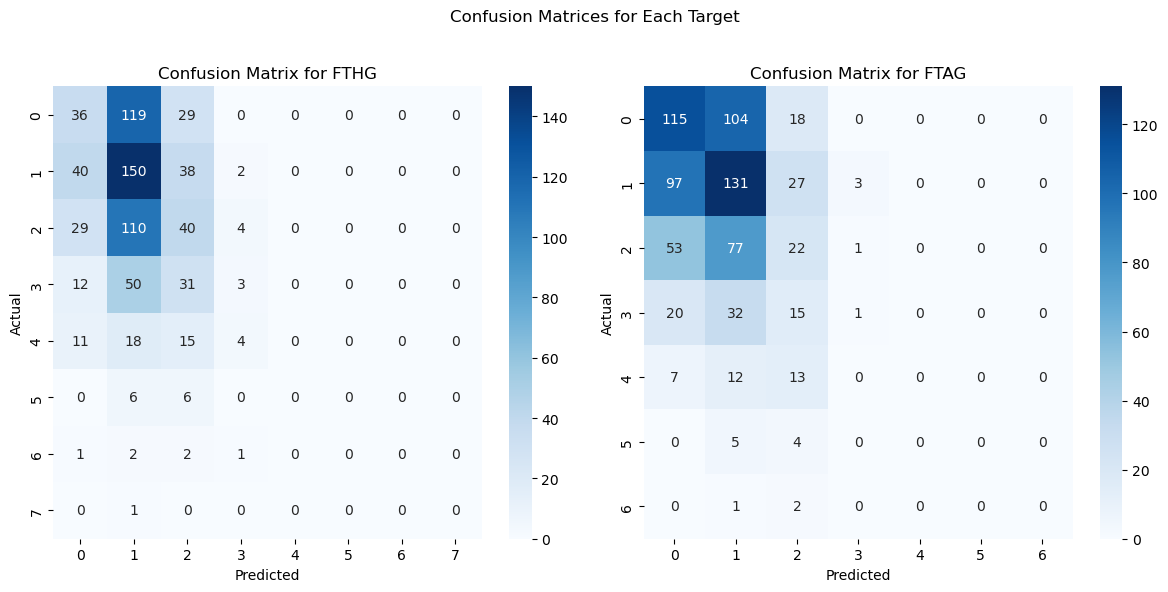

{'FTHG': 0.3013157894736842, 'FTAG': 0.3539473684210526}

In [ ]:
# Initialize the RandomForestClassifier and wrap it with MultiOutputClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
multi_output_rf_model = MultiOutputClassifier(rf_model)

evaluate_classification_model(
    multi_output_rf_model,
    X_train,
    X_val,
    y_train,
    y_val,
    target_names=["FTHG", "FTAG"],
)

Classification Report for FTHG:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       184
           1       0.30      1.00      0.46       230
           2       1.00      0.00      0.00       183
           3       1.00      0.00      0.00        96
           4       1.00      0.00      0.00        48
           5       1.00      0.00      0.00        12
           6       1.00      0.00      0.00         7

    accuracy                           0.30       760
   macro avg       0.90      0.14      0.07       760
weighted avg       0.79      0.30      0.14       760

Accuracy for FTHG: 0.3026315789473684

Classification Report for FTAG:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       237
           1       0.34      1.00      0.51       258
           2       1.00      0.00      0.00       153
           3       1.00      0.00      0.00        68
           4       1.00      

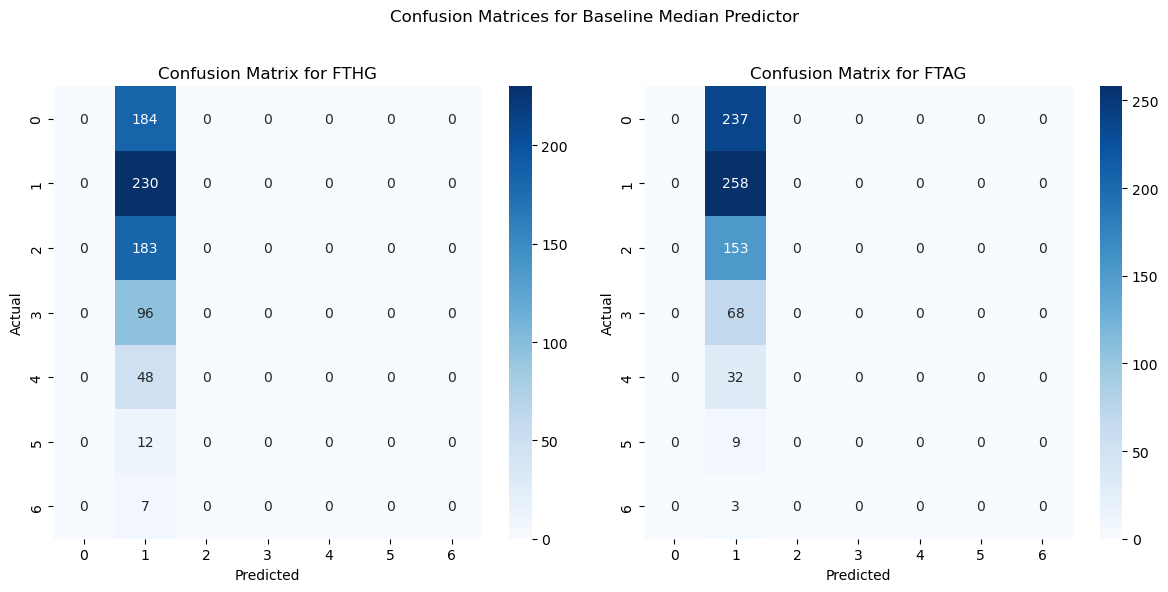

{'FTHG': 0.3026315789473684, 'FTAG': 0.3394736842105263}

In [ ]:
def compute_result(df):
    """
    Compute the match result based on FTHG and FTAG.

    Parameters:
    - df: DataFrame containing 'FTHG' and 'FTAG' columns.

    Returns:
    - DataFrame with a new 'Result' column.
    """
    conditions = [
        (df["FTHG"] > df["FTAG"]),
        (df["FTHG"] == df["FTAG"]),
        (df["FTHG"] < df["FTAG"]),
    ]
    choices = ["Home Win", "Draw", "Away Win"]
    df["Result"] = pd.Categorical.from_codes(
        [
            choices.index(
                next(choice for i, choice in enumerate(choices) if condition[i])
            )
            for condition in zip(*conditions, strict=False)
        ],
        categories=choices,
    )
    return df


def convert_to_discrete(y, bins):
    """
    Convert continuous values to discrete classes based on bins.

    Parameters:
    - y: Continuous values (e.g., predicted FTHG or FTAG).
    - bins: List of bin edges defining the discrete classes.

    Returns:
    - Discrete class labels based on the bin edges.
    """
    return np.digitize(y, bins=bins) - 1


### Save Best Model

In [ ]:
from app.core.config.paths import SAVED_MODELS_DIRECTORY
from app.services.models.save_load import save_model

save_model(model_nn, "nn", SAVED_MODELS_DIRECTORY)